# Arabic Dialect Identification using a Transformer-Based Models

## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch import nn
from torch.utils.data import DataLoader
import re
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


## Read and clean data

In [3]:
train = pd.read_csv("/kaggle/input/wwowoww/strat_train_set.csv", lineterminator='\n')
val = pd.read_csv("/kaggle/input/wwowoww/strat_dev_set.csv")
test = pd.read_csv("/kaggle/input/wwowoww/strat_test_set.csv")

In [4]:
train.head()

,id,dialect,text
0,1174699325378715648,LB,@Jamal_Moghrabi @CAROLE_SAMAHA شعب ما بيعرف ال...
1,891013156553850880,LB,@SensitiveEmotin @slam116 إيه بعرف بس هوي سؤال...
2,896660728731635712,SY,@EltaherMano @ititalotibi دايما يسبنا ابناء ال...
3,1165385853482545152,SA,@QMonira لن يجد اللاعب هالراتب في اوروبا وفلام...
4,1109904055462252416,EG,@NiMoo1121 التراب دا اساسي الفترة دي قولي ليه\...


In [5]:
train.drop(columns=['id'],inplace=True)
val.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)

In [6]:
train = train.astype(str)
test = test.astype(str)
val = val.astype(str)

In [7]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
val.drop_duplicates(inplace=True)

## Dialect Label with its corresponding country

Dialect | Country
---- | -----------
LB | Lebanon
SY | Syria
SA | Saudi Arabia
EG | Egypt
AE | United Arab Emirates
MA | Morroco
QA | Qatar
LY | Libya
PL | Palestine
KW | Kwait
YE | Yemen
JO | Jordan
BH | Bahrain
IQ | Iraq
OM | Oman
SD | Sudan
DZ | Algeria
TN | Tunisia

In [8]:
class preprocessing:

  def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    return sentence

  def cleaning(sentence):
    '''
      Argument:
          string of words
      return:
          string of words but after removing punctuations
    '''
    text = re.sub(r'[a-zA-Z0-9_#&*$,]',"",sentence)
    text = re.sub(r'[^\w\s]',"",text)
    
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('arabic'))
    tokens = [word for word in tokens if word not in stop_words]

    # Perform stemming
    #stemmer = ISRIStemmer()
    #tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

  def preprocess(sentence):
    '''
    Argument:
        string of words
    return:
        string of words after cleaning
    '''
    clean = preprocessing.normalize(sentence)
    clean = preprocessing.cleaning(clean)
    return clean

In [9]:
train['text'] = train['text'].apply(preprocessing.preprocess)
test['text'] = test['text'].apply(preprocessing.preprocess)
val['text'] = val['text'].apply(preprocessing.preprocess)

In [10]:
train.head()

,dialect,text
0,LB,شعب بيعرف الواحد بدو يرضي للاسف
1,LB,ايه بعرف هوي سءال انكار علي لاعب كبير حقق الكث...
2,SY,دايما يسبنا ابناء الاجنبيات بيسب معناتو حتي بنتي
3,SA,يجد اللاعب هالراتب اوروبا وفلامنجو ماراح يحصل ...
4,EG,التراب دا اساسي الفتره دي قولي ليه عشان تنضفي ...


In [11]:
train['dialect'].value_counts()

dialect
EG    55353
PL    42010
KW    40442
LY    35053
QA    29839
JO    26816
LB    26524
SA    25769
AE    25254
BH    25251
OM    18359
SY    15599
DZ    15542
IQ    14883
SD    13862
MA    11082
YE     9534
TN     8880
Name: count, dtype: int64

# EDA & Visualization

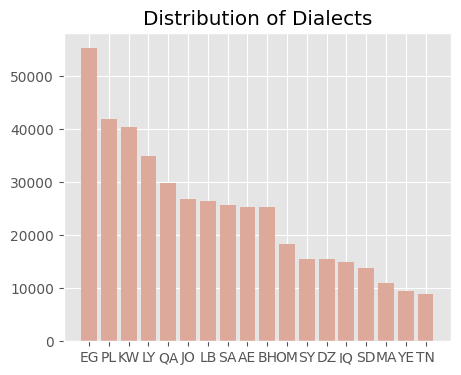

In [12]:
fig = plt.figure(figsize =(5, 4))
plt.bar(train['dialect'].value_counts().index, train['dialect'].value_counts(),color ='#DCA99A');
plt.title("Distribution of Dialects");
plt.savefig("diall.png")

In [13]:
temp = train.groupby('dialect').count()['text'].reset_index().sort_values(by='text',ascending=False)[:5]

In [14]:
fig = go.Figure(go.Funnelarea(
    text =temp.dialect,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Dialect Distribution"}
    ))
fig.show()

In [15]:
train['temp_list'] = train['text'].apply(lambda x:str(x).split())

In [16]:
EG = train[train['dialect']=='EG']
PL = train[train['dialect']=='PL']
KW = train[train['dialect']=='KW']
LY = train[train['dialect']=='LY']
QA = train[train['dialect']=='QA']

In [17]:
#MosT common EG words
top = Counter([item for sublist in EG['temp_list'] for item in sublist])
temp_eg = pd.DataFrame(top.most_common(10))
temp_eg.columns = ['Common_words','count']
temp_eg.style.background_gradient(cmap='Reds')

,Common_words,count
0,اللي,12920
1,مش,10408
2,علي,8983
3,ده,8283
4,انا,6545
5,دي,5394
6,ايه,5166
7,ان,4141
8,كده,3684
9,حاجه,3345


In [18]:
fig = px.treemap(temp_eg, path=['Common_words'], values='count',title='Tree Of Most Common EG Words')
fig.show()

In [19]:
#MosT common PL words
top = Counter([item for sublist in PL['temp_list'] for item in sublist])
temp_pl = pd.DataFrame(top.most_common(10))
temp_pl.columns = ['Common_words','count']
temp_pl.style.background_gradient(cmap='Greens')

,Common_words,count
0,مش,5443
1,اللي,4396
2,انا,4320
3,الله,4215
4,علي,3126
5,والله,2781
6,الي,2369
7,شو,1839
8,هيك,1753
9,عشان,1645


In [20]:
fig = px.treemap(temp_pl, path=['Common_words'], values='count',title='Tree Of Most Common PL Words')
fig.show()

In [21]:
#MosT common KW words
top = Counter([item for sublist in KW['temp_list'] for item in sublist])
temp_kw = pd.DataFrame(top.most_common(10))
temp_kw.columns = ['Common_words','count']
temp_kw.style.background_gradient(cmap='Greys')

,Common_words,count
0,اللي,7418
1,علي,6432
2,الله,5567
3,مو,3538
4,انا,2907
5,شي,2526
6,والله,2483
7,ان,2181
8,اذا,1799
9,الي,1584


In [22]:
fig = px.treemap(temp_kw, path=['Common_words'], values='count',title='Tree Of Most Common KW Words')
fig.show()

In [23]:
#MosT common LY words
top = Counter([item for sublist in LY['temp_list'] for item in sublist])
temp_ly = pd.DataFrame(top.most_common(10))
temp_ly.columns = ['Common_words','count']
temp_ly.style.background_gradient(cmap='Oranges')

,Common_words,count
0,اللي,5919
1,علي,4119
2,مش,3863
3,الله,3234
4,انا,2153
5,ان,1866
6,والله,1668
7,حتي,1578
8,ربي,1542
9,انت,1359


In [24]:
fig = px.treemap(temp_ly, path=['Common_words'], values='count',title='Tree Of Most Common LY Words')
fig.show()

In [25]:
#MosT common QA words
top = Counter([item for sublist in QA['temp_list'] for item in sublist])
temp_qa = pd.DataFrame(top.most_common(10))
temp_qa.columns = ['Common_words','count']
temp_qa.style.background_gradient(cmap='Blues')

,Common_words,count
0,علي,4916
1,اللي,4635
2,الله,4392
3,قطر,2412
4,والله,2356
5,انت,2003
6,ان,2000
7,الي,1919
8,انا,1818
9,شي,1761


In [26]:
fig = px.treemap(temp_qa, path=['Common_words'], values='count',title='Tree Of Most Common QA Words')
fig.show()

## Prepare Data for model

In [27]:
label2id = {'LB': 0, 'SY': 0, 'SA': 1, 'EG': 2, 'AE': 1, 'MA': 3, 'QA': 1, 'LY': 4, 'PL': 0, 'KW': 1, 'YE': 1, 'JO': 0,
           'BH': 1, 'IQ': 1, 'OM': 1, 'SD': 2, 'DZ': 3, 'TN': 3}
id2label = { v:k for k,v in label2id.items()}

train['dialect'] = train['dialect'].map(label2id)
val['dialect'] = val['dialect'].map(label2id)
test['dialect'] = test['dialect'].map(label2id)

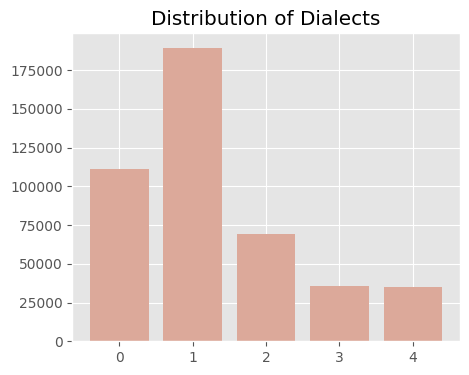

In [28]:
fig = plt.figure(figsize =(5, 4))
plt.bar(train['dialect'].value_counts().index, train['dialect'].value_counts(),color ='#DCA99A');
plt.title("Distribution of Dialects");
plt.savefig("diall2.png")

In [29]:
def create_balanced_sample(df, label_column):
    # Group by the label column and find the minimum class size
    min_class_size = df.groupby(label_column).size().min()

    # Sample min_class_size instances from each class
    balanced_sample = df.groupby(label_column).apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

    return balanced_sample

train = create_balanced_sample(train, 'dialect')

In [30]:
# Function to take a stratified sample
def stratified_sample(df, col, frac=0.20):
    return df.groupby(col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Taking a 20% stratified sample
train = stratified_sample(train, 'dialect', frac=0.55)

In [31]:
train['dialect'].value_counts()

dialect
0    19279
1    19279
2    19279
3    19279
4    19279
Name: count, dtype: int64

In [32]:
train.drop('temp_list', axis=1, inplace=True)
train.drop_duplicates(inplace=True)

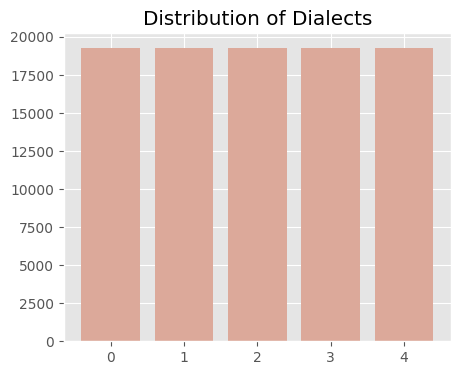

In [33]:
fig = plt.figure(figsize =(5, 4))
plt.bar(train['dialect'].value_counts().index, train['dialect'].value_counts(),color ='#DCA99A');
plt.title("Distribution of Dialects");
plt.savefig("diall3.png")

In [34]:
train.dropna(inplace=True)
val.dropna(inplace=True)
test.dropna(inplace=True)

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score

In [36]:
# Define metrics
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  g_mean = geometric_mean_score(labels, preds)


  return {'Accuracy Score': acc, 'F1 Score': f1, 'G_Mean': g_mean, 'Precision Score': precision, 'Recall Score': recall}

In [37]:
class DialectsDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(int(self.labels[idx]))
      return item

  def __len__(self):
      return len(self.labels)

In [38]:
train_labels = train['dialect']
val_labels = val['dialect']
test_labels = test['dialect']

# MODEL 1

In [39]:
model1 = AutoModelForSequenceClassification.from_pretrained('UBC-NLP/MARBERTv2', num_labels=5)
tokenizer1 = BertTokenizerFast.from_pretrained('UBC-NLP/MARBERTv2')

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [40]:
model1.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [41]:
model1.device

device(type='cuda', index=0)

### Encode text & prepare dataloader

In [42]:
train_encodings1 = tokenizer1(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings1 = tokenizer1(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings1 = tokenizer1(test['text'].to_list(), truncation=True, padding=True, max_length=60)

In [43]:
ds_train1 = DialectsDataset(train_encodings1, train_labels)
ds_val1 =  DialectsDataset(val_encodings1, val_labels)
ds_test1 =  DialectsDataset(test_encodings1, test_labels)

### Training Arguments

In [44]:
training_args1 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer1 = Trainer(
    model=model1,                         
    args=training_args1,                 
    train_dataset=ds_train1,
    eval_dataset=ds_val1,                       
    compute_metrics=compute_metrics,
    
)

## Training

In [45]:
trainer1.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,0.880100,0.633505,0.786883,0.742840,0.773164,0.723758,0.774890
2,0.603200,0.565883,0.809799,0.769760,0.783202,0.757550,0.785807
3,0.526200,0.576511,0.806416,0.763214,0.784261,0.746714,0.786583
4,0.466000,0.607241,0.799433,0.756829,0.787895,0.737336,0.789523
5,0.436000,0.609172,0.800524,0.758770,0.787354,0.738897,0.788840


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



TrainOutput(global_step=3765, training_loss=0.5700887875094673, metrics={'train_runtime': 3064.1858, 'train_samples_per_second': 157.255, 'train_steps_per_second': 1.229, 'total_flos': 1.48577470462152e+16, 'train_loss': 0.5700887875094673, 'epoch': 5.0})

In [46]:
trainer1.evaluate(ds_test1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.6318742036819458,
 'eval_Accuracy Score': 0.7941209219463311,
 'eval_F1 Score': 0.7497800578699139,
 'eval_G_Mean': 0.776934484339326,
 'eval_Precision Score': 0.7301528010652192,
 'eval_Recall Score': 0.7788188816896867,
 'eval_runtime': 23.0155,
 'eval_samples_per_second': 390.215,
 'eval_steps_per_second': 6.126,
 'epoch': 5.0}

# MODEL 2

In [47]:
# Load pretrained model
model2 = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", 
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id)
tokenizer2 = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

model2.to(device)
model2.device

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

device(type='cuda', index=0)

In [48]:
train_encodings2 = tokenizer2(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings2 = tokenizer2(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings2 = tokenizer2(test['text'].to_list(), truncation=True, padding=True, max_length=60)

ds_train2 = DialectsDataset(train_encodings2, train_labels)
ds_val2 =  DialectsDataset(val_encodings2, val_labels)
ds_test2 =  DialectsDataset(test_encodings2, test_labels)

In [49]:
training_args2 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer2 = Trainer(
    model=model2,                         
    args=training_args2,                 
    train_dataset=ds_train2,
    eval_dataset=ds_val2,                       
    compute_metrics=compute_metrics,
    
)

In [50]:
trainer2.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,1.149900,0.886319,0.687691,0.625629,0.647034,0.613637,0.653577
2,0.921000,0.780994,0.727630,0.669381,0.674363,0.658945,0.683746
3,0.863000,0.764348,0.729594,0.672837,0.691900,0.657863,0.696505
4,0.808800,0.757868,0.733304,0.679307,0.700158,0.663502,0.704034
5,0.789700,0.750491,0.733741,0.680612,0.699608,0.665401,0.703605


Checkpoint destination directory results/checkpoint-753 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-1506 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-2259 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors w

TrainOutput(global_step=3765, training_loss=0.897676035765791, metrics={'train_runtime': 2923.9379, 'train_samples_per_second': 164.798, 'train_steps_per_second': 1.288, 'total_flos': 1.48577470462152e+16, 'train_loss': 0.897676035765791, 'epoch': 5.0})

In [51]:
trainer2.evaluate(ds_test2)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.7766627073287964,
 'eval_Accuracy Score': 0.7260884088631555,
 'eval_F1 Score': 0.6715958160997106,
 'eval_G_Mean': 0.6909203187328726,
 'eval_Precision Score': 0.6560155097277793,
 'eval_Recall Score': 0.6951436997727727,
 'eval_runtime': 21.6213,
 'eval_samples_per_second': 415.378,
 'eval_steps_per_second': 6.521,
 'epoch': 5.0}

# MODEL 3

In [52]:
# Load pretrained model
model3 = AutoModelForSequenceClassification.from_pretrained("bashar-talafha/multi-dialect-bert-base-arabic", 
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id)
tokenizer3 = AutoTokenizer.from_pretrained("bashar-talafha/multi-dialect-bert-base-arabic")

model3.to(device)
model3.device

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bashar-talafha/multi-dialect-bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

device(type='cuda', index=0)

In [53]:
train_encodings3 = tokenizer3(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings3 = tokenizer3(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings3 = tokenizer3(test['text'].to_list(), truncation=True, padding=True, max_length=60)

ds_train3 = DialectsDataset(train_encodings3, train_labels)
ds_val3 =  DialectsDataset(val_encodings3, val_labels)
ds_test3 =  DialectsDataset(test_encodings3, test_labels)

In [54]:
training_args3 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer3 = Trainer(
    model=model3,                         
    args=training_args3,                 
    train_dataset=ds_train3,
    eval_dataset=ds_val3,                       
    compute_metrics=compute_metrics,
    
)

In [55]:
trainer3.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,0.996300,0.763797,0.733959,0.673275,0.692788,0.662189,0.699003
2,0.772600,0.698238,0.754911,0.698924,0.713256,0.689009,0.719646
3,0.707300,0.705477,0.758075,0.705898,0.730047,0.691945,0.734039
4,0.646300,0.706524,0.757202,0.706161,0.734385,0.690357,0.737882
5,0.620000,0.693345,0.759821,0.707920,0.728561,0.693948,0.732624


Checkpoint destination directory results/checkpoint-753 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-1506 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-2259 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors w

TrainOutput(global_step=3765, training_loss=0.7406880858726552, metrics={'train_runtime': 2805.4132, 'train_samples_per_second': 171.761, 'train_steps_per_second': 1.342, 'total_flos': 1.48577470462152e+16, 'train_loss': 0.7406880858726552, 'epoch': 5.0})

In [56]:
trainer3.evaluate(ds_test3)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.7056511044502258,
 'eval_Accuracy Score': 0.7539249526778755,
 'eval_F1 Score': 0.7022371254079252,
 'eval_G_Mean': 0.7212330679820369,
 'eval_Precision Score': 0.6881478042335869,
 'eval_Recall Score': 0.7254187354215436,
 'eval_runtime': 22.0588,
 'eval_samples_per_second': 407.139,
 'eval_steps_per_second': 6.392,
 'epoch': 5.0}

# MODEL 4

In [57]:
model4 = AutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-mix", 
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id)
tokenizer4 = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-mix")

model4.to(device)
model4.device

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

device(type='cuda', index=0)

In [58]:
train_encodings4 = tokenizer4(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings4 = tokenizer4(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings4 = tokenizer4(test['text'].to_list(), truncation=True, padding=True, max_length=60)

ds_train4 = DialectsDataset(train_encodings4, train_labels)
ds_val4 =  DialectsDataset(val_encodings4, val_labels)
ds_test4 =  DialectsDataset(test_encodings4, test_labels)

In [59]:
training_args4 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer4 = Trainer(
    model=model4,                         
    args=training_args4,                 
    train_dataset=ds_train4,
    eval_dataset=ds_val4,                       
    compute_metrics=compute_metrics,
    
)

In [60]:
trainer4.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,0.975500,0.720787,0.745635,0.689086,0.715447,0.677937,0.719742
2,0.721400,0.653348,0.770188,0.719543,0.735035,0.711170,0.739940
3,0.651800,0.680804,0.760694,0.711302,0.743252,0.698564,0.745960
4,0.587600,0.660771,0.767351,0.718085,0.743564,0.699949,0.746001
5,0.552800,0.665064,0.769860,0.721166,0.746837,0.704030,0.749023


Checkpoint destination directory results/checkpoint-753 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-1506 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-2259 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors w

TrainOutput(global_step=3765, training_loss=0.6875916459487571, metrics={'train_runtime': 2797.0953, 'train_samples_per_second': 172.272, 'train_steps_per_second': 1.346, 'total_flos': 1.48577470462152e+16, 'train_loss': 0.6875916459487571, 'epoch': 5.0})

In [61]:
trainer4.evaluate(ds_test4)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.6842176914215088,
 'eval_Accuracy Score': 0.7635007237501392,
 'eval_F1 Score': 0.7148629932757746,
 'eval_G_Mean': 0.7430579425268051,
 'eval_Precision Score': 0.6957839821260182,
 'eval_Recall Score': 0.7451269220128297,
 'eval_runtime': 22.1291,
 'eval_samples_per_second': 405.846,
 'eval_steps_per_second': 6.372,
 'epoch': 5.0}

# MODEL 5

In [62]:
model5 = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02-twitter", 
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           ignore_mismatched_sizes=True)
tokenizer5 = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02-twitter")

model5.to(device)
model5.device

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

device(type='cuda', index=0)

In [63]:
train_encodings5 = tokenizer5(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings5 = tokenizer5(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings5 = tokenizer5(test['text'].to_list(), truncation=True, padding=True, max_length=60)

ds_train5 = DialectsDataset(train_encodings5, train_labels)
ds_val5 =  DialectsDataset(val_encodings5, val_labels)
ds_test5 =  DialectsDataset(test_encodings5, test_labels)

In [64]:
training_args5 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer5 = Trainer(
    model=model5,                         
    args=training_args5,                 
    train_dataset=ds_train5,
    eval_dataset=ds_val5,                       
    compute_metrics=compute_metrics,
    
)

In [65]:
trainer5.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,0.909800,0.705917,0.760039,0.709312,0.729479,0.693906,0.734044
2,0.722300,0.643347,0.780336,0.729021,0.737401,0.720390,0.742655
3,0.671200,0.655067,0.768878,0.717728,0.743139,0.702764,0.746262
4,0.626800,0.664454,0.771170,0.721971,0.750084,0.705063,0.753151
5,0.606300,0.660755,0.772152,0.723507,0.749138,0.706657,0.752054


Checkpoint destination directory results/checkpoint-753 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-1506 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-2259 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors w

TrainOutput(global_step=3765, training_loss=0.699394754964517, metrics={'train_runtime': 2925.7386, 'train_samples_per_second': 164.697, 'train_steps_per_second': 1.287, 'total_flos': 1.48577470462152e+16, 'train_loss': 0.699394754964517, 'epoch': 5.0})

In [66]:
trainer5.evaluate(ds_test5)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.6660140752792358,
 'eval_Accuracy Score': 0.7676205322347177,
 'eval_F1 Score': 0.7150001115245742,
 'eval_G_Mean': 0.7393425598616034,
 'eval_Precision Score': 0.6977679169200469,
 'eval_Recall Score': 0.7425439327504411,
 'eval_runtime': 21.7369,
 'eval_samples_per_second': 413.169,
 'eval_steps_per_second': 6.487,
 'epoch': 5.0}

# Model 6

In [67]:
model6 = AutoModelForSequenceClassification.from_pretrained("Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city", 
                                                           num_labels=5,
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           ignore_mismatched_sizes=True)
tokenizer6 = AutoTokenizer.from_pretrained("Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city")

model6.to(device)
model6.device

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([26, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([26]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

device(type='cuda', index=0)

In [68]:
train_encodings6 = tokenizer6(train['text'].to_list(), truncation=True, padding=True, max_length=60)
val_encodings6 = tokenizer6(val['text'].to_list(), truncation=True, padding=True, max_length=60)
test_encodings6 = tokenizer6(test['text'].to_list(), truncation=True, padding=True, max_length=60)

ds_train6 = DialectsDataset(train_encodings6, train_labels)
ds_val6 =  DialectsDataset(val_encodings6, val_labels)
ds_test6 =  DialectsDataset(test_encodings6, test_labels)

In [69]:
training_args6 = TrainingArguments(
    output_dir='results',          
    num_train_epochs=5,
    learning_rate=0.00001,
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,       
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer6 = Trainer(
    model=model6,                         
    args=training_args6,                 
    train_dataset=ds_train6,
    eval_dataset=ds_val6,                       
    compute_metrics=compute_metrics,
    
)

In [70]:
trainer6.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy score,F1 score,G Mean,Precision score,Recall score
1,562056231416080802558080263913472.000000,541681747855612218414918679920640.000000,0.168485,0.129868,0.078612,0.133796,0.188915
2,561729256789384473412623616966656.000000,541681747855612218414918679920640.000000,0.168485,0.129868,0.078612,0.133796,0.188915
3,559361919293458246358417239179264.000000,541681747855612218414918679920640.000000,0.168485,0.129868,0.078612,0.133796,0.188915
4,561892110277432502829833733013504.000000,541681747855612218414918679920640.000000,0.168485,0.129868,0.078612,0.133796,0.188915
5,562219520659022677146508961251328.000000,541681747855612218414918679920640.000000,0.168485,0.129868,0.078612,0.133796,0.188915


Checkpoint destination directory results/checkpoint-753 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-1506 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

Checkpoint destination directory results/checkpoint-2259 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors w

TrainOutput(global_step=3765, training_loss=5.6203439990124914e+32, metrics={'train_runtime': 3029.8051, 'train_samples_per_second': 159.04, 'train_steps_per_second': 1.243, 'total_flos': 1.48577470462152e+16, 'train_loss': 5.6203439990124914e+32, 'epoch': 5.0})

In [71]:
trainer6.evaluate(ds_test6)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 5.3933631570868115e+32,
 'eval_Accuracy Score': 0.16768733993987306,
 'eval_F1 Score': 0.12755397409000008,
 'eval_G_Mean': 0.06571512567014627,
 'eval_Precision Score': 0.12640408270200826,
 'eval_Recall Score': 0.18707627496250404,
 'eval_runtime': 23.3272,
 'eval_samples_per_second': 385.001,
 'eval_steps_per_second': 6.044,
 'epoch': 5.0}

# Best Model Interpretation

In [72]:
!pip install transformers-interpret

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 759.7 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for captum>=0.3.1 from https://files.pythonhosted.org/packages/e1/76/b21bfd2c35cab2e9a4b68b1977f7488c246c8cffa31e3361ee7610e8b5af/captum-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ipython
    Found existing installation: ipython 8.14.0
    Uninstalling ipython-8.14.0:
      Successfully uninstalled ipython-8.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incomp

In [73]:
from transformers_interpret import SequenceClassificationExplainer

In [74]:
cls_explainer = SequenceClassificationExplainer(
    model1,
    tokenizer1)

def interpret(explainer,text,TrueClass,name):
  word_attributions = explainer(text)
  explainer.visualize(name,true_class=TrueClass)
  return word_attributions

In [78]:
word_attributions = interpret(cls_explainer," ازاي ماكنتش هناك ؟",2,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_2 (0.85),LABEL_2,1.91,[CLS] ازاي ماكنتش هناك ؟ [SEP]


In [84]:
word_attributions = interpret(cls_explainer,"شلونك يخوي عساك طيب",1,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.94),LABEL_1,1.63,[CLS] شلونك يخوي عساك طيب [SEP]
